In [1]:
%matplotlib inline
import sys
import scipy as sp
import os
import pickle
import h5py
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sb
import glob
import pandas as pd

In [2]:
basedir_meta = '/cluster/work/grlab/projects/metagenome/data/gtex/align_samples'
basedir_star = '/cluster/work/grlab/projects/metagenome/data/gtex/alignments_star/results/alignments'
K = 41
files_meta = glob.glob(os.path.join(basedir_meta, 'realign.*.k%i.summary.txt' % K))
files_meta_map = glob.glob(os.path.join(basedir_meta, 'remap.*.k%i.summary.txt' % K))
files_star = glob.glob(os.path.join(basedir_star, '*.all.summary.txt'))

In [18]:
### collect metagraph alignments
samples_meta = []
all_counts_meta = []
for fname in files_meta:
    sample = os.path.basename(fname).split('.')[1]
    counts = sp.zeros((77,), dtype='int')
    for line in open(fname, 'r'):
        sl = line.strip().split('\t')
        counts[int(sl[0])] = int(sl[1])
    samples_meta.append(sample)
    all_counts_meta.append(counts)
samples_meta_map = []
all_counts_meta_map = []
for fname in files_meta_map:
    sample = os.path.basename(fname).split('.')[1]
    counts = sp.zeros((77,), dtype='int')
    for line in open(fname, 'r'):
        sl = line.strip().split('\t')
        counts[int(sl[0])] = int(sl[1])
    samples_meta_map.append(sample)
    all_counts_meta_map.append(counts)
### collect star alignments
samples_star = []
all_counts_star = []
for fname in files_star:
    sample = os.path.basename(fname).split('.')[0]
    counts = sp.zeros((77,), dtype='int')
    for line in open(fname, 'r'):
        sl = line.strip().split('\t')
        counts[int(sl[0])] = int(sl[1])
    samples_star.append(sample)
    all_counts_star.append(counts)

In [19]:
df = dict()
df['meta_align'] = pd.DataFrame(sp.array(all_counts_meta), index=sp.array(samples_meta))
df['meta_align'] = df['meta_align'].assign(tmp=df['meta_align'].sum(1)).sort_values('tmp', ascending=False).drop('tmp',1)
df['meta_map'] = pd.DataFrame(sp.array(all_counts_meta_map), index=sp.array(samples_meta_map))
df['meta_map'] = df['meta_map'].assign(tmp=df['meta_map'].sum(1)).sort_values('tmp', ascending=False).drop('tmp',1)
df['star'] = pd.DataFrame(sp.array(all_counts_star), index=sp.array(samples_star))
df['star'] = df['star'].assign(tmp=df['star'].sum(1)).sort_values('tmp', ascending=False).drop('tmp',1)
df['star'] = df['star'].loc[df['meta_align'].index] ### account for some samples still missing for MetaGraph

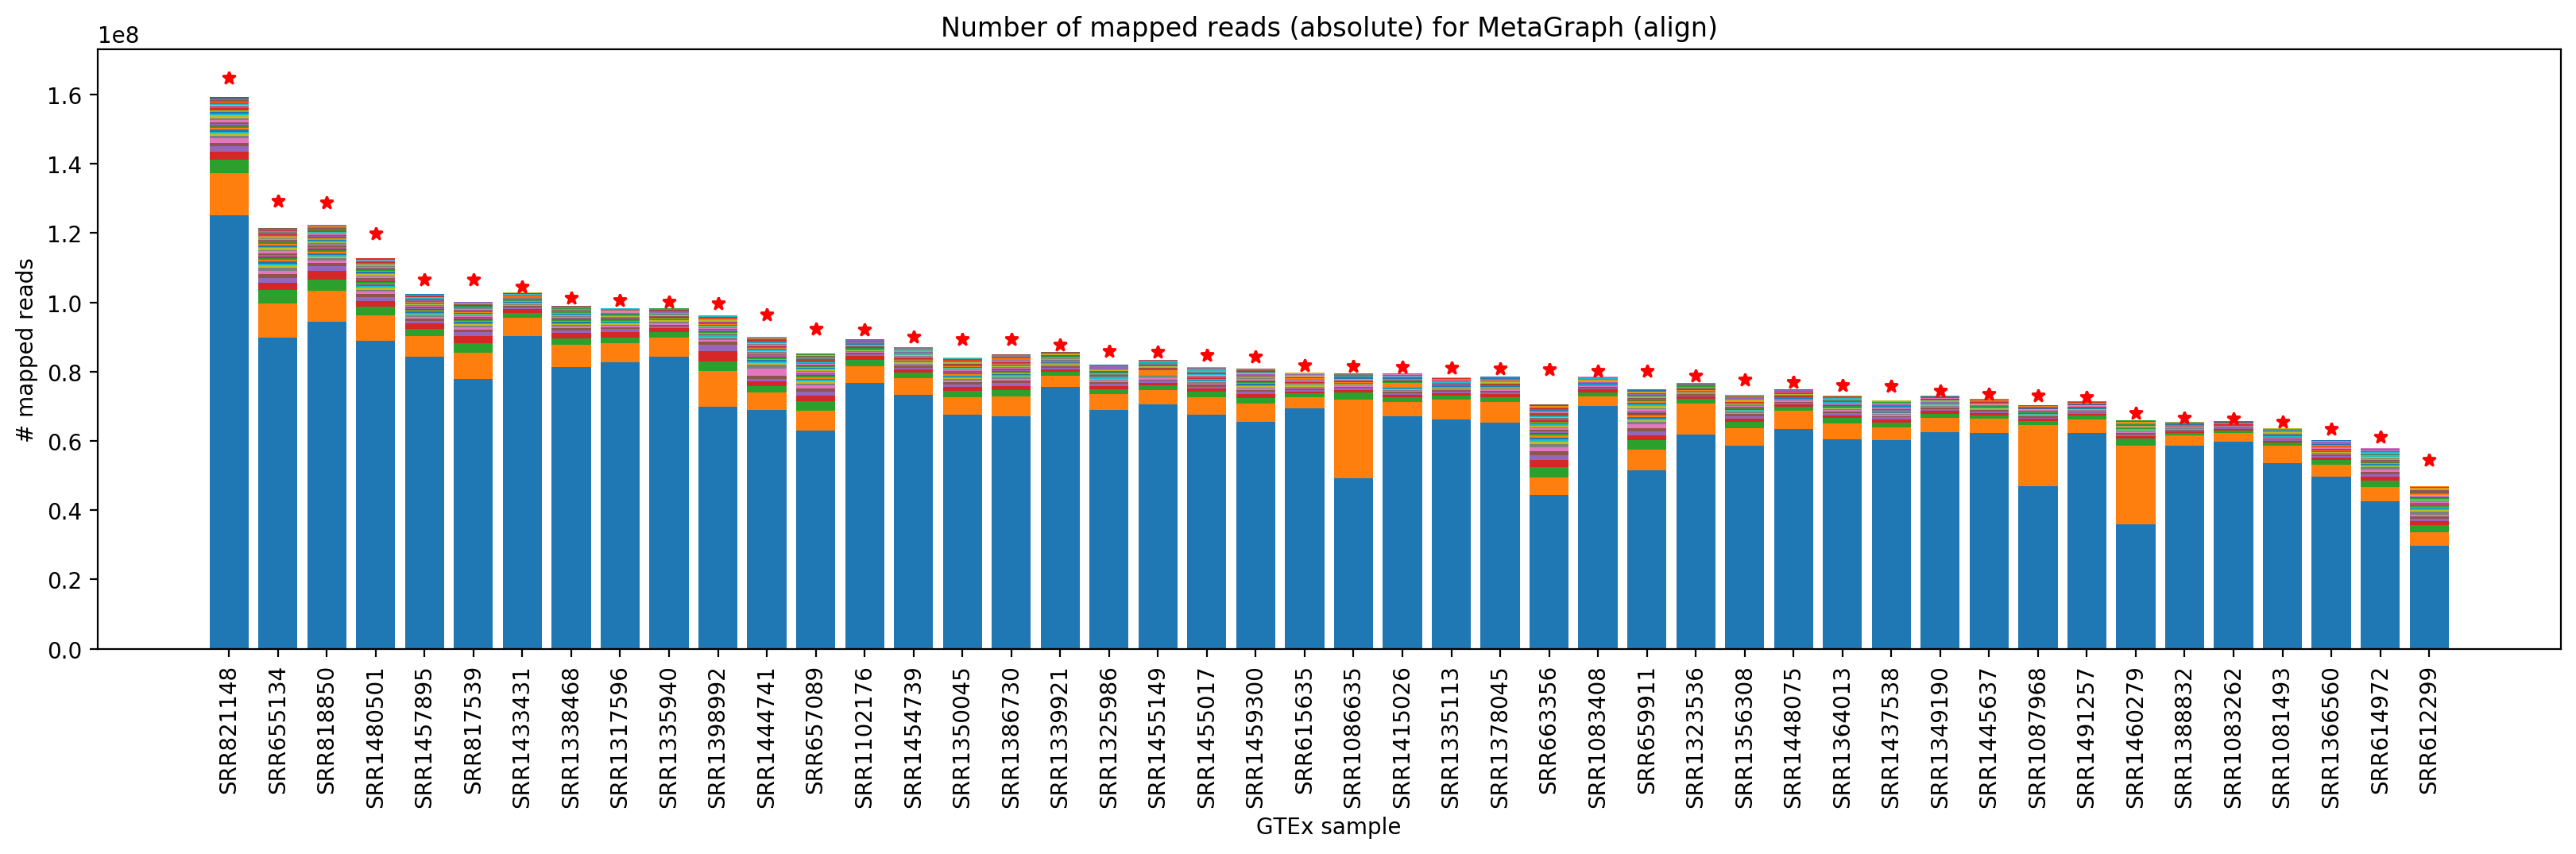

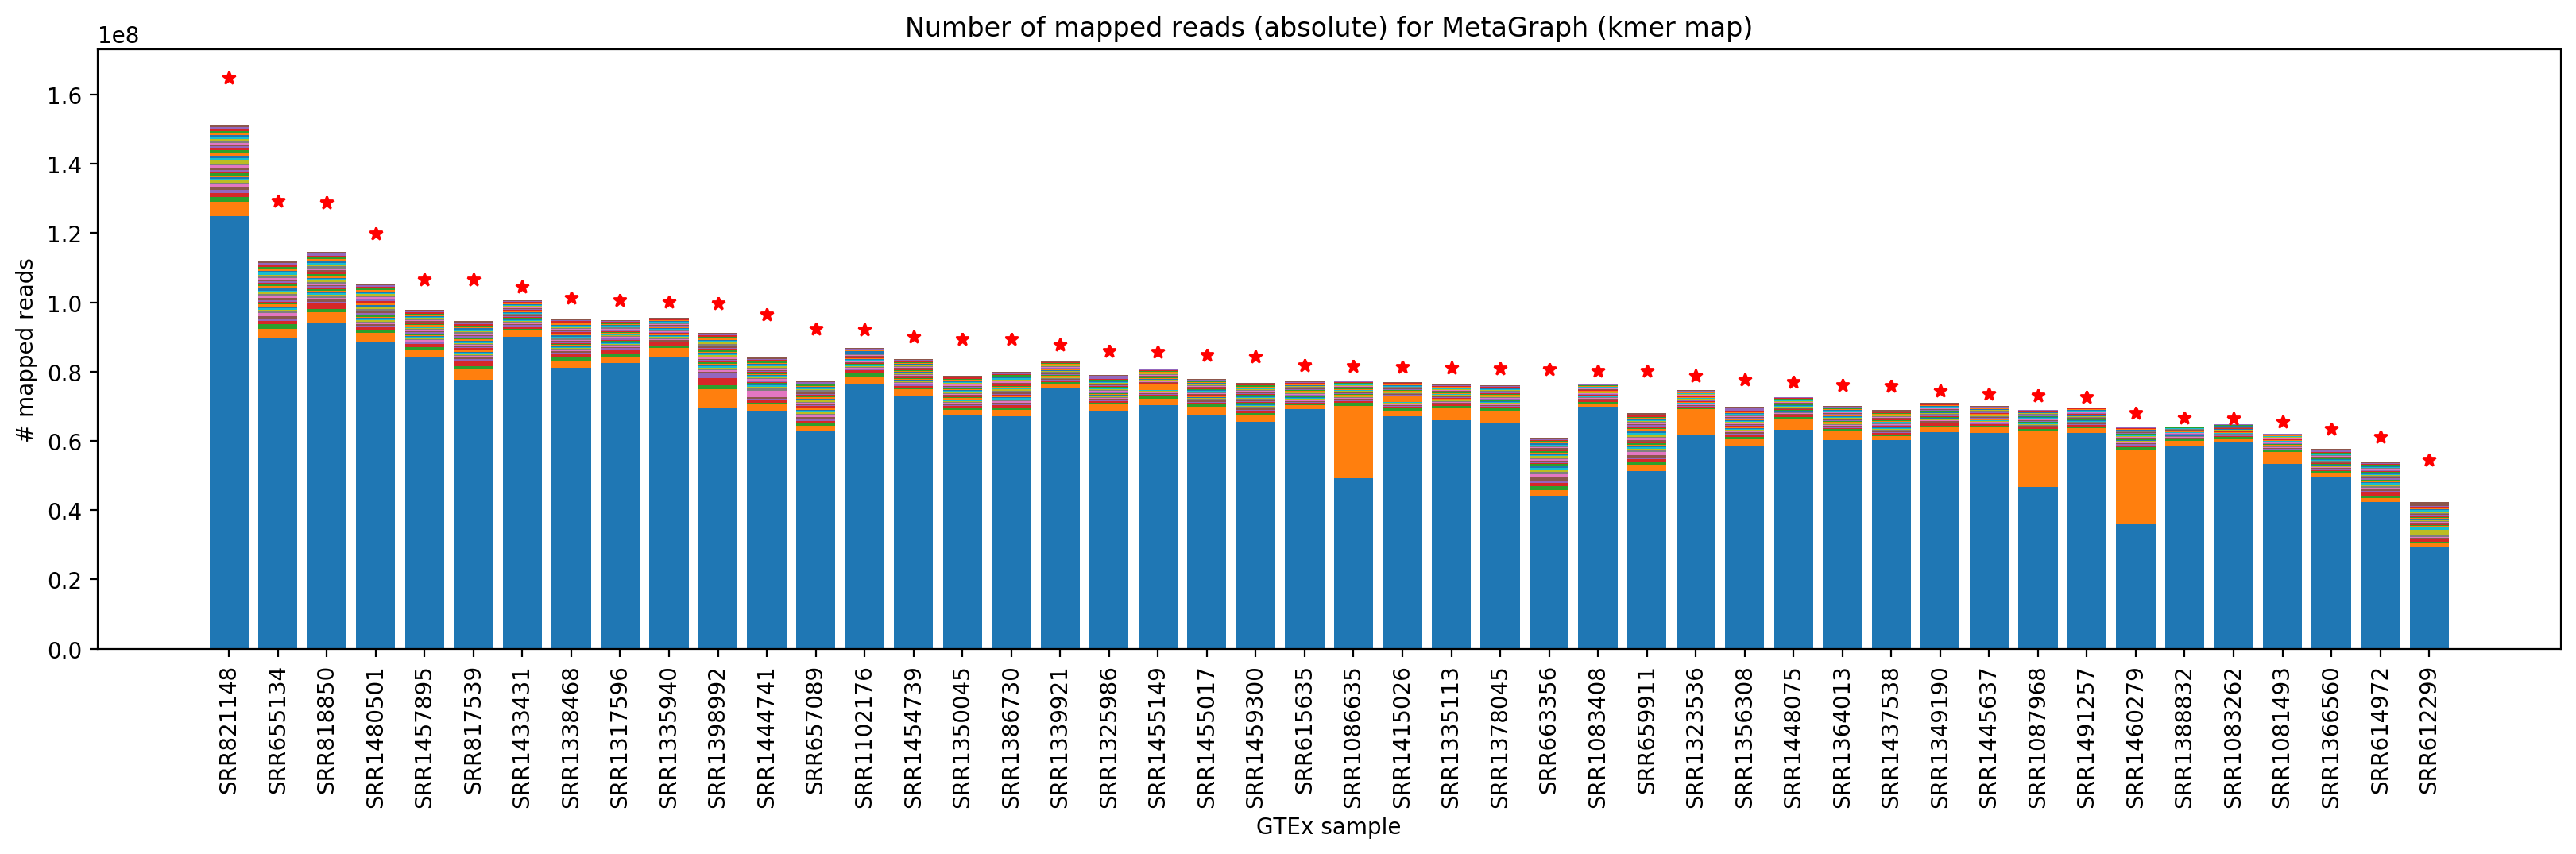

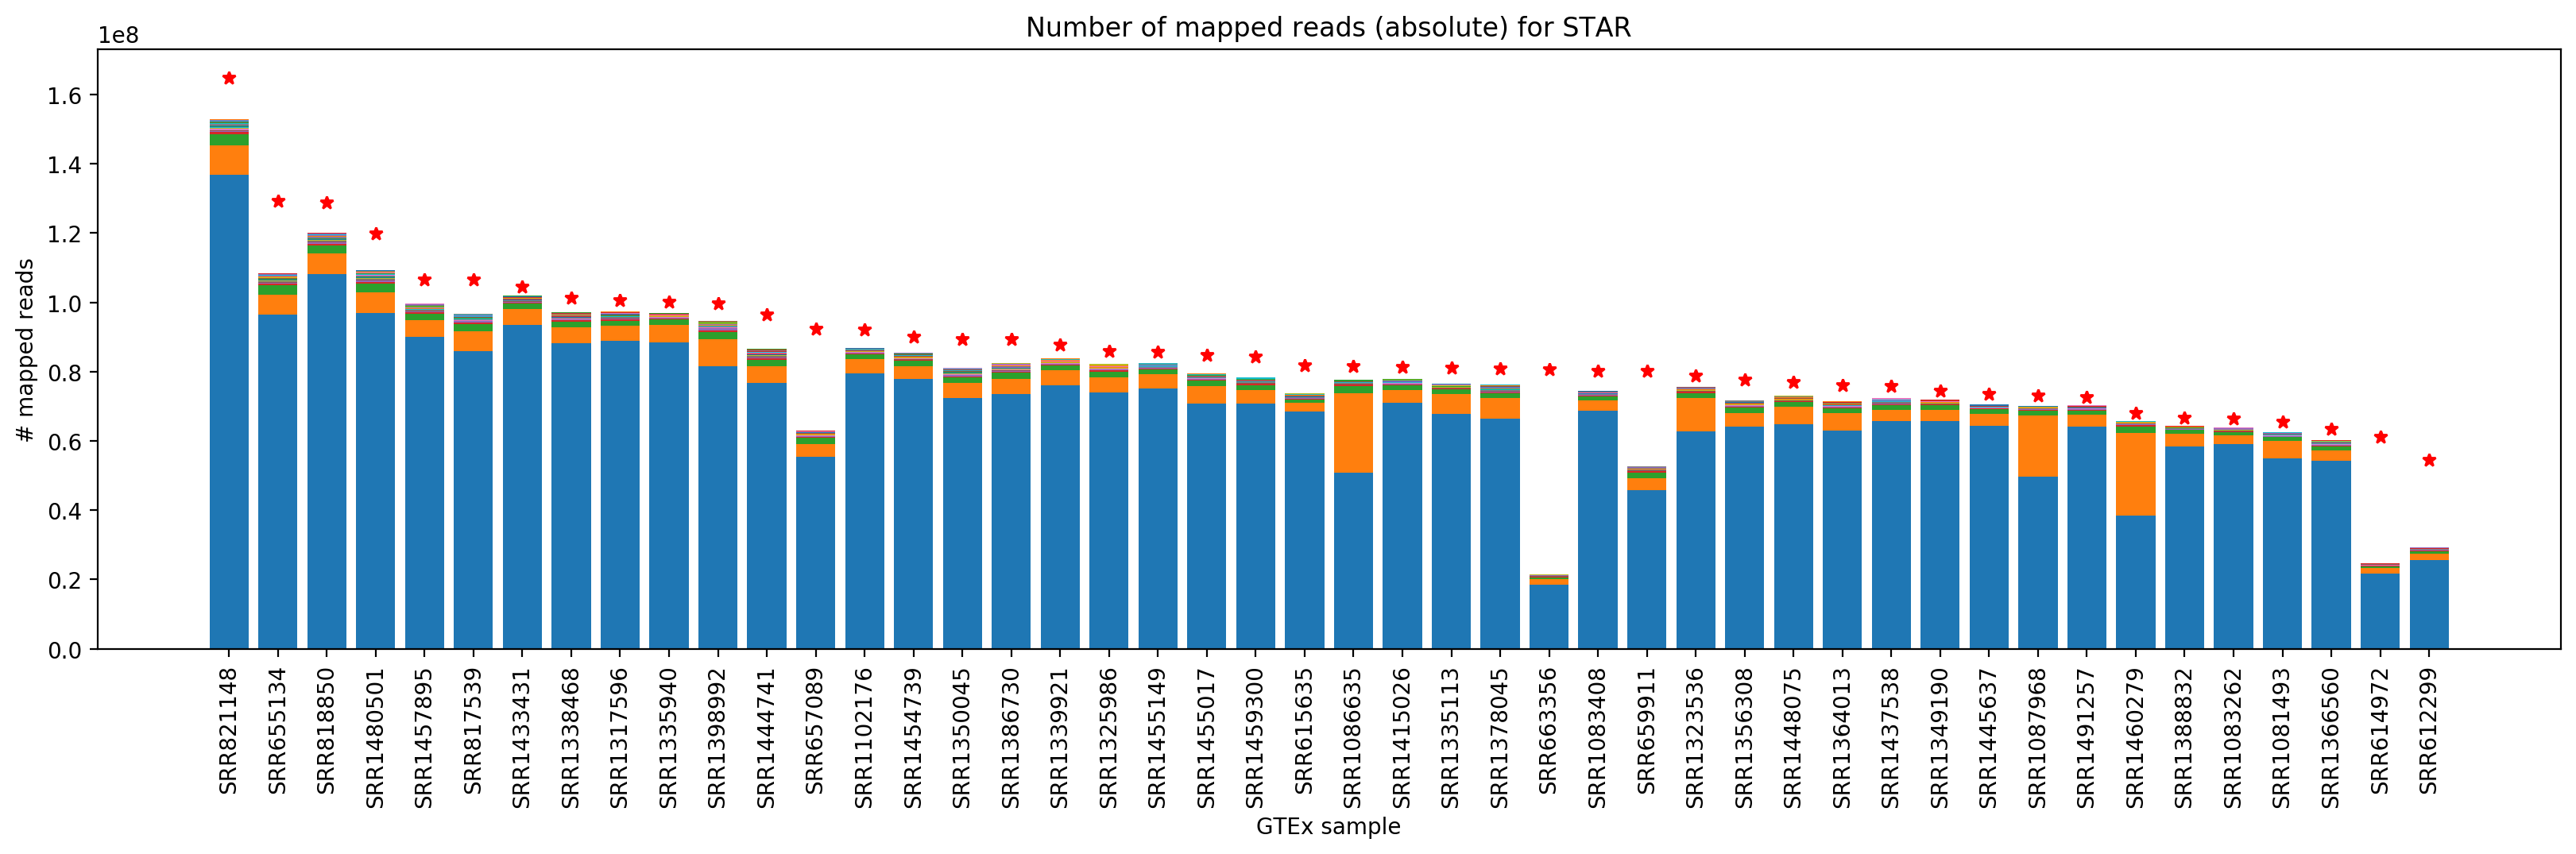

In [20]:
method = {'meta_align':'MetaGraph (align)', 'meta_map':'MetaGraph (kmer map)', 'star':'STAR'}
for key in ['meta_align', 'meta_map', 'star']:
    fig = plt.figure(figsize=(20, 5), dpi=200)
    ax = fig.add_subplot(111)
    for i in df[key].columns[:76]:
        if i == 0:
            ax.bar(sp.arange(df[key].shape[0]), df[key].iloc[:, i]) # color='b', alpha=0.8)
            cum_sum = df[key].iloc[:, i].copy()
        else:
            ax.bar(sp.arange(df[key].shape[0]), df[key].iloc[:, i], bottom=cum_sum) #, color='b', alpha=0.8 - (i / 150.0))
            cum_sum += df[key].iloc[:, i]
    ax.set_xticks(sp.arange(df[key].shape[0]))
    ax.set_xticklabels(df[key].index, rotation=90)
    ax.set_ylabel('# mapped reads')
    ax.set_xlabel('GTEx sample')
    ax.plot(sp.arange(df[key].shape[0]), cum_sum + df[key].iloc[:, 76], 'r*')
    ax.set_title('Number of mapped reads (absolute) for %s' % method[key])

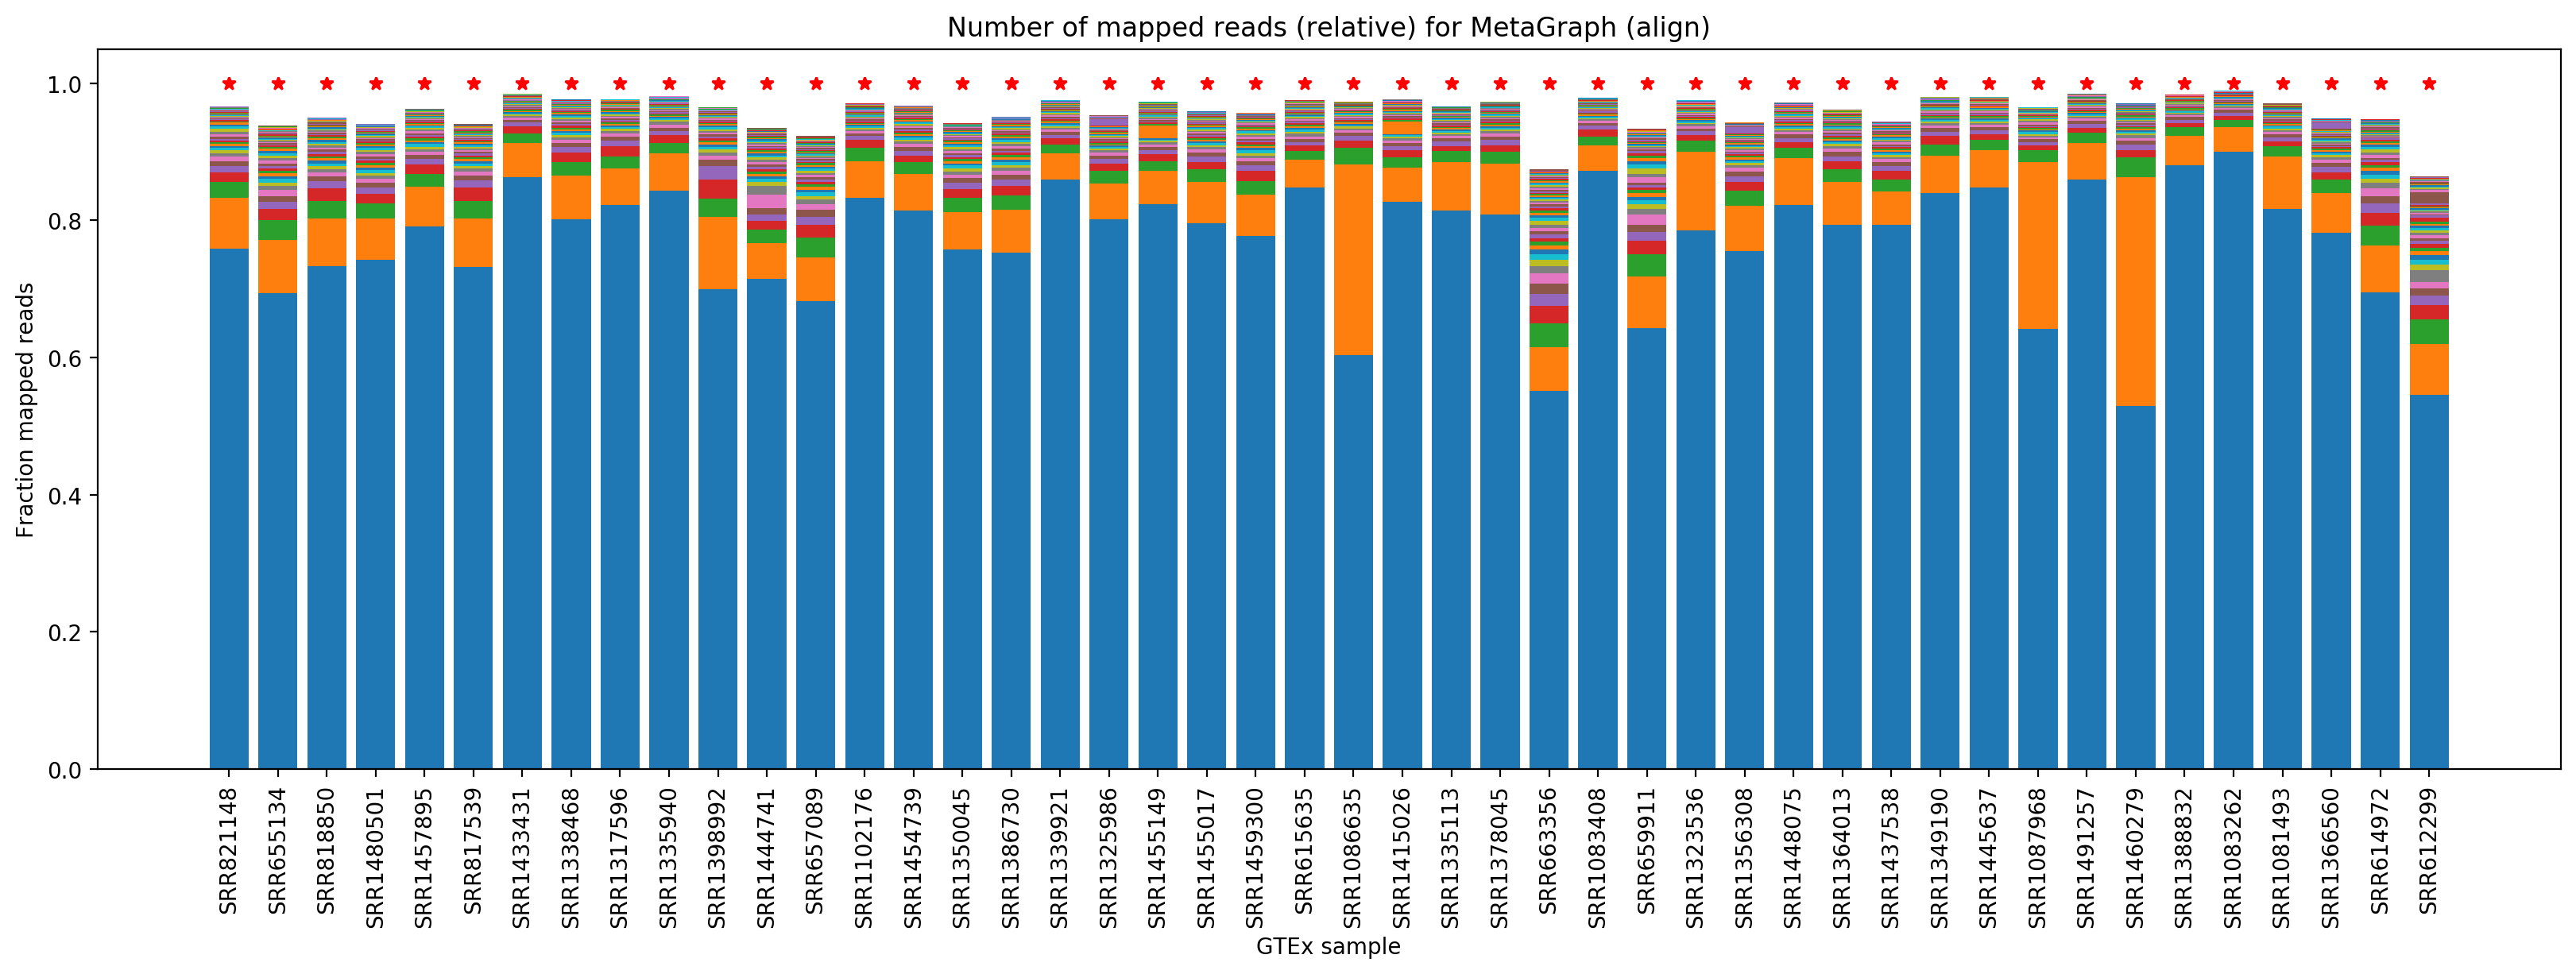

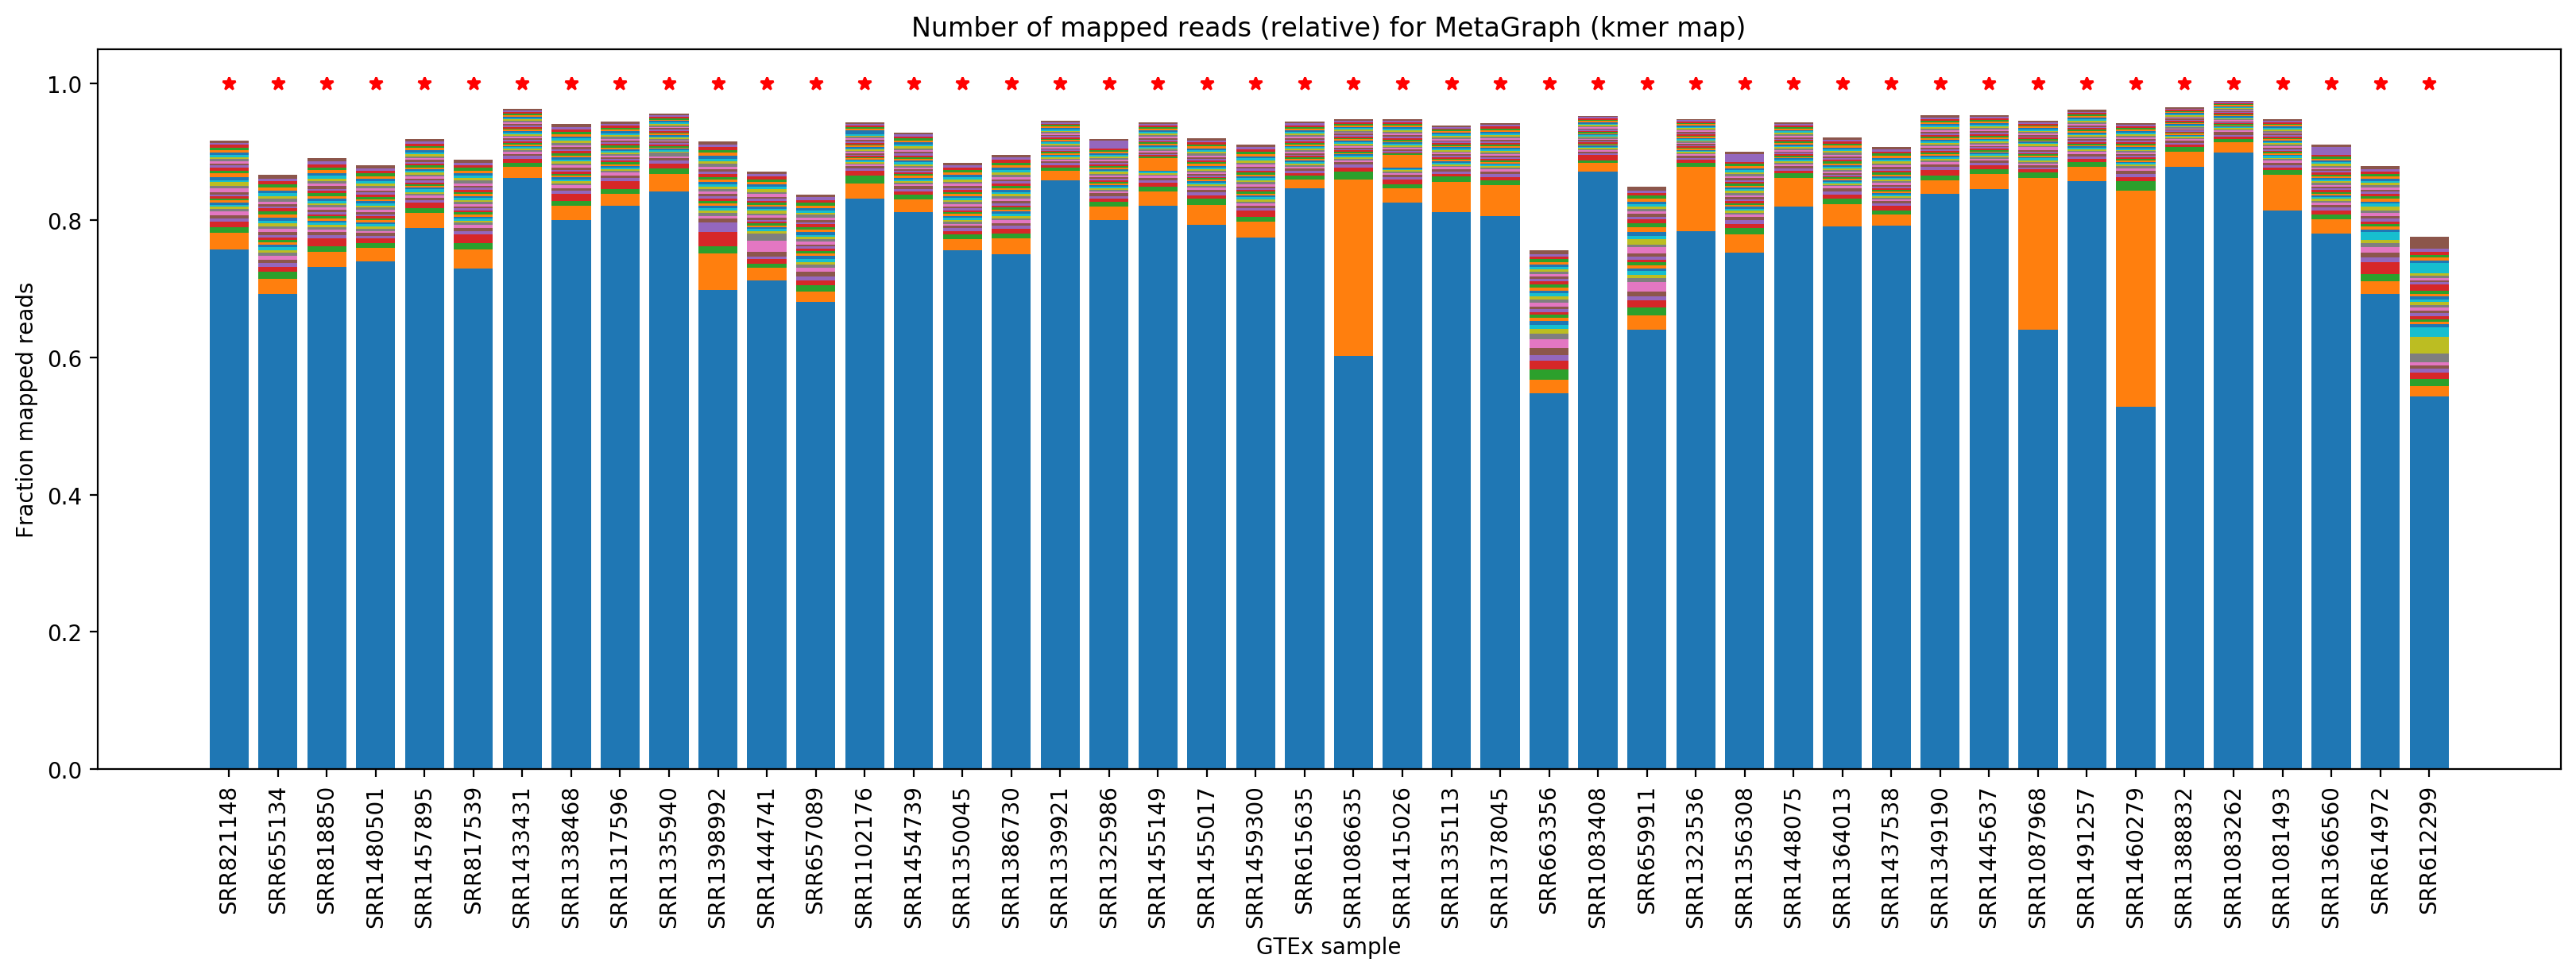

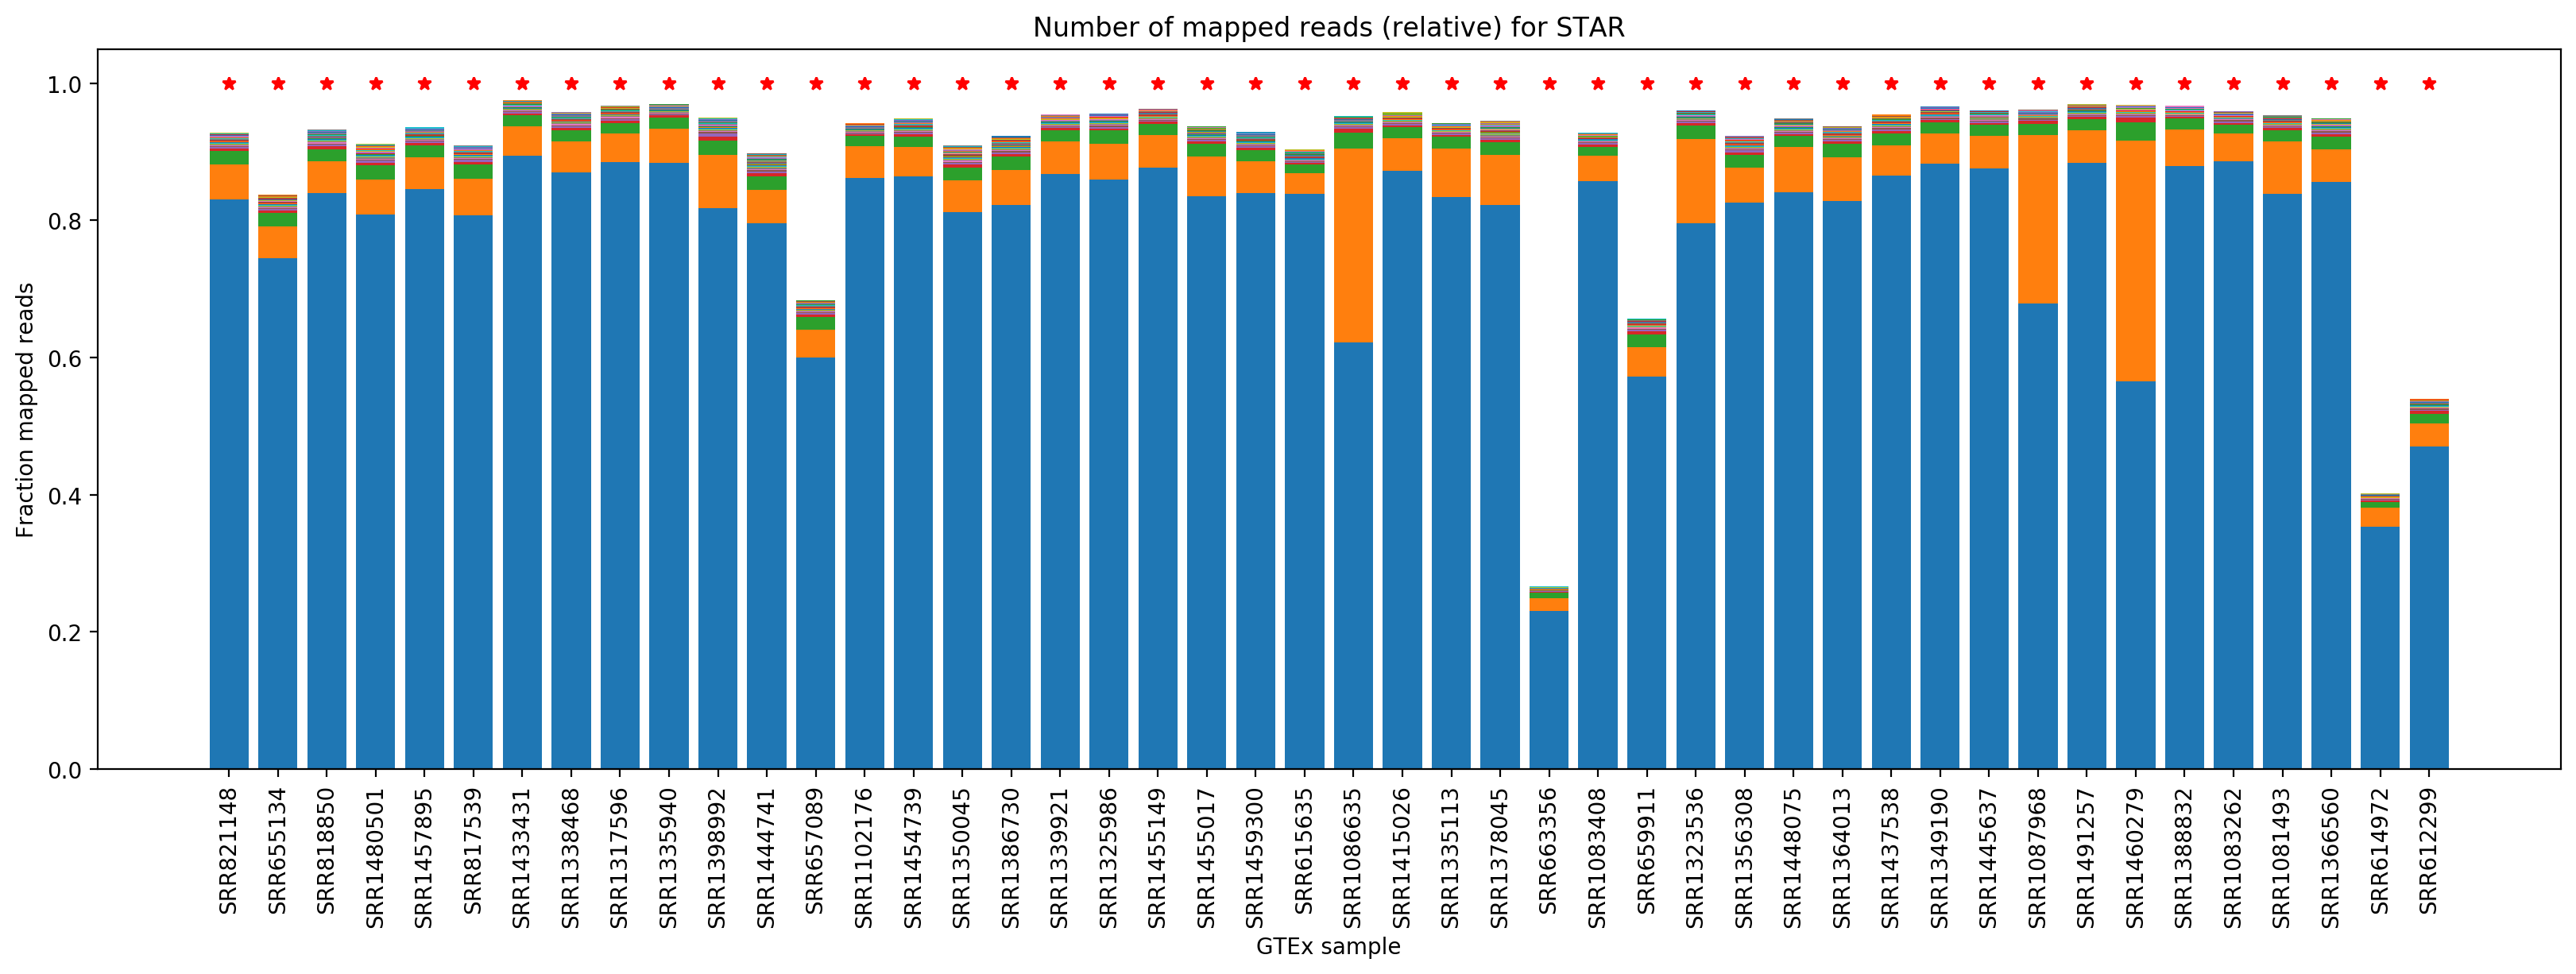

In [21]:
method = {'meta_align':'MetaGraph (align)', 'meta_map':'MetaGraph (kmer map)', 'star':'STAR'}
for key in ['meta_align', 'meta_map','star']:
    total = df[key].sum(1)
    fig = plt.figure(figsize=(20, 6), dpi=200)
    ax = fig.add_subplot(111)
    for i in df[key].columns[:76]:
        if i == 0:
            ax.bar(sp.arange(df[key].shape[0]), df[key].iloc[:, i] / total) # color='b', alpha=0.8)
            cum_sum = (df[key].iloc[:, i] / total)
        else:
            ax.bar(sp.arange(df[key].shape[0]), df[key].iloc[:, i] / total, bottom=cum_sum) #, color='b', alpha=0.8 - (i / 150.0))
            cum_sum += (df[key].iloc[:, i] / total)
    ax.set_xticks(sp.arange(df[key].shape[0]))
    ax.set_xticklabels(df[key].index, rotation=90)
    ax.set_ylabel('Fraction mapped reads')
    ax.set_xlabel('GTEx sample')
    ax.plot(sp.arange(df[key].shape[0]), cum_sum + (df[key].iloc[:, 76] / total), 'r*')
    ax.set_title('Number of mapped reads (relative) for %s' % method[key])

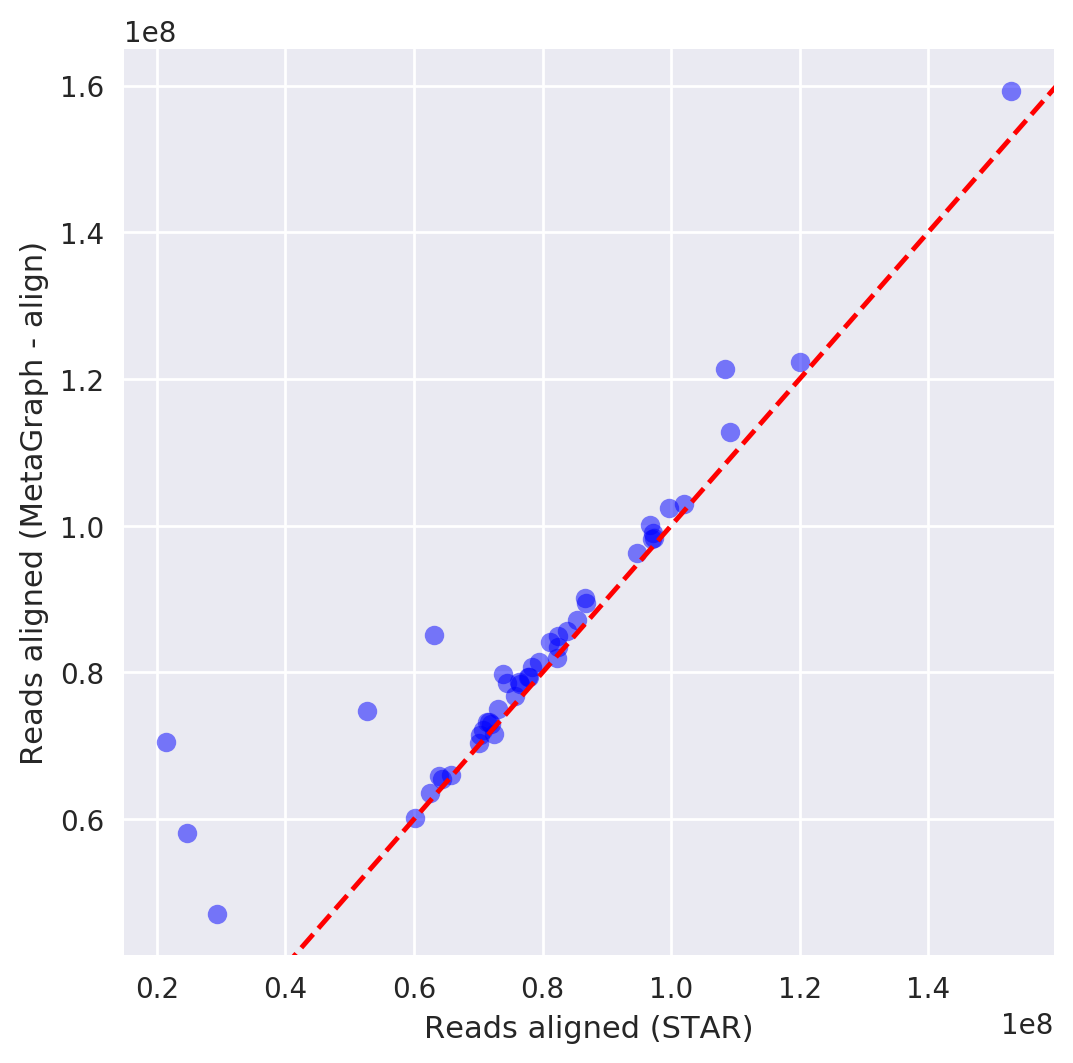

In [23]:
with plt.style.context('seaborn'):
    fig = plt.figure(figsize=(6, 6), dpi=200)
    ax = fig.add_subplot(111)
    ax.plot(df['star'].sum(1) - df['star'][76], df['meta_align'].sum(1) - df['meta_align'][76], 'bo', alpha=0.5)
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    t = max(ylim[1], xlim[1])
    ax.plot([0, t], [0, t], 'r--')
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_xlabel('Reads aligned (STAR)')
    ax.set_ylabel('Reads aligned (MetaGraph - align)')

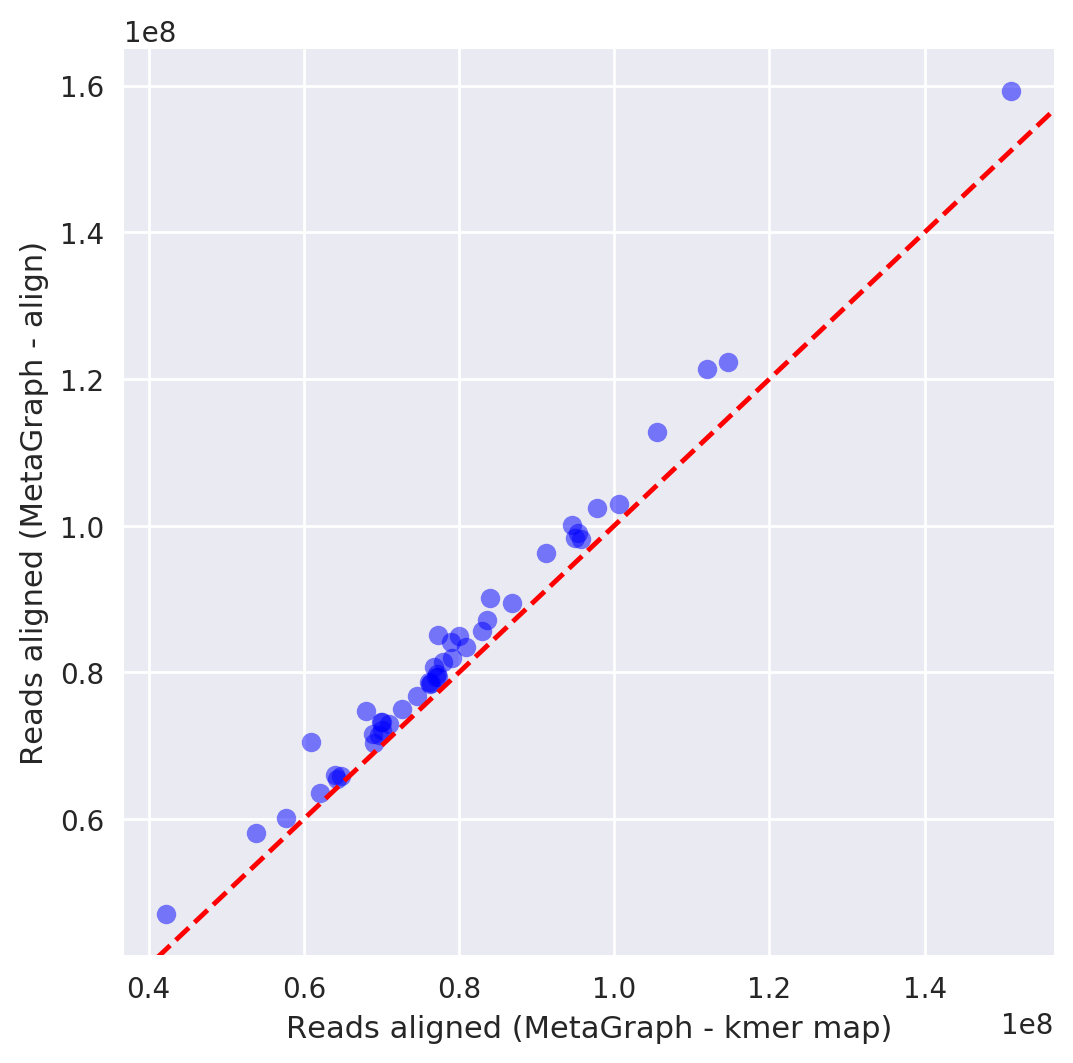

In [25]:
with plt.style.context('seaborn'):
    fig = plt.figure(figsize=(6, 6), dpi=200)
    ax = fig.add_subplot(111)
    ax.plot(df['meta_map'].sum(1) - df['meta_map'][76], df['meta_align'].sum(1) - df['meta_align'][76], 'bo', alpha=0.5)
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    t = max(ylim[1], xlim[1])
    ax.plot([0, t], [0, t], 'r--')
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_xlabel('Reads aligned (MetaGraph - kmer map)')
    ax.set_ylabel('Reads aligned (MetaGraph - align)')

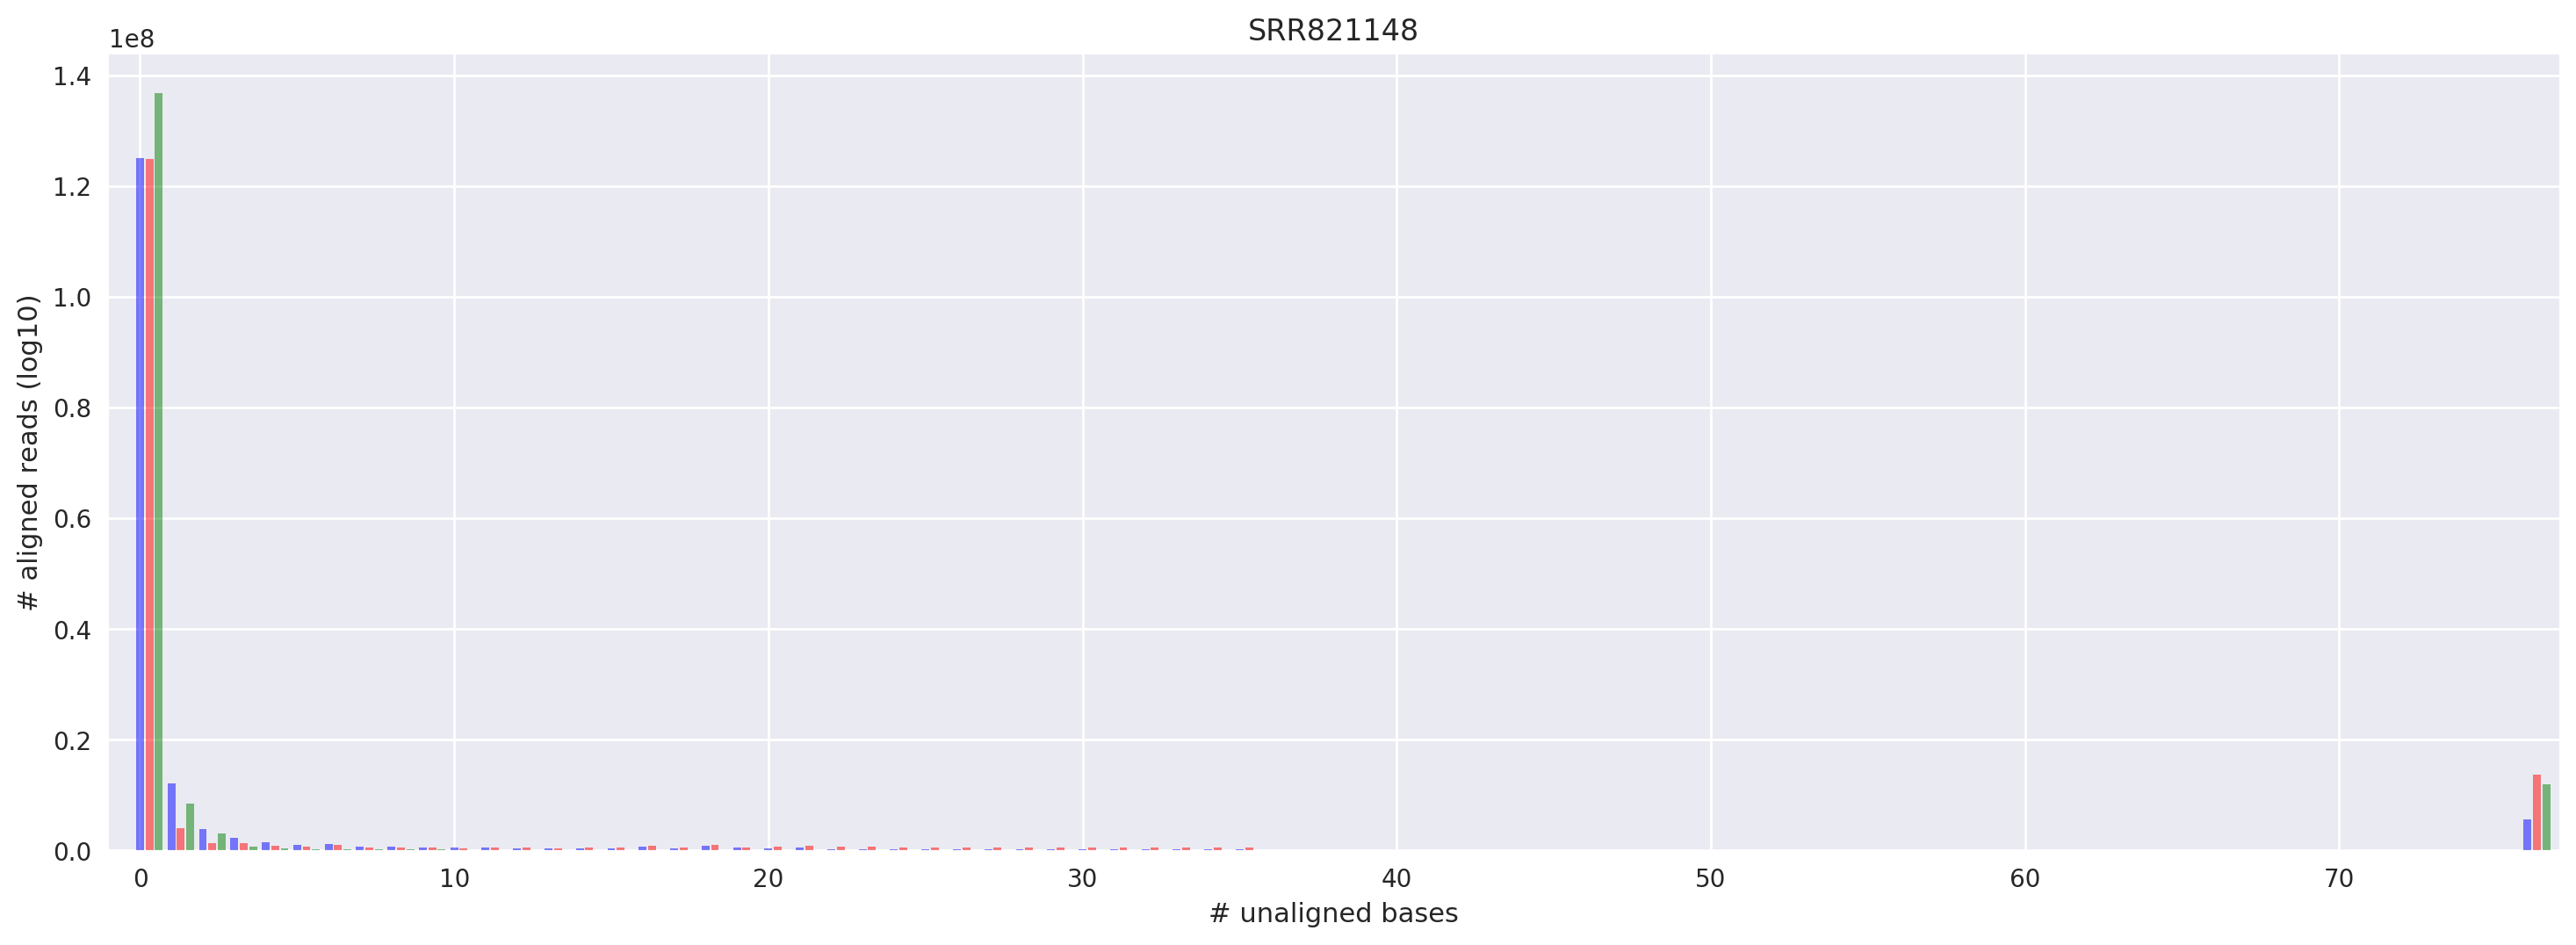

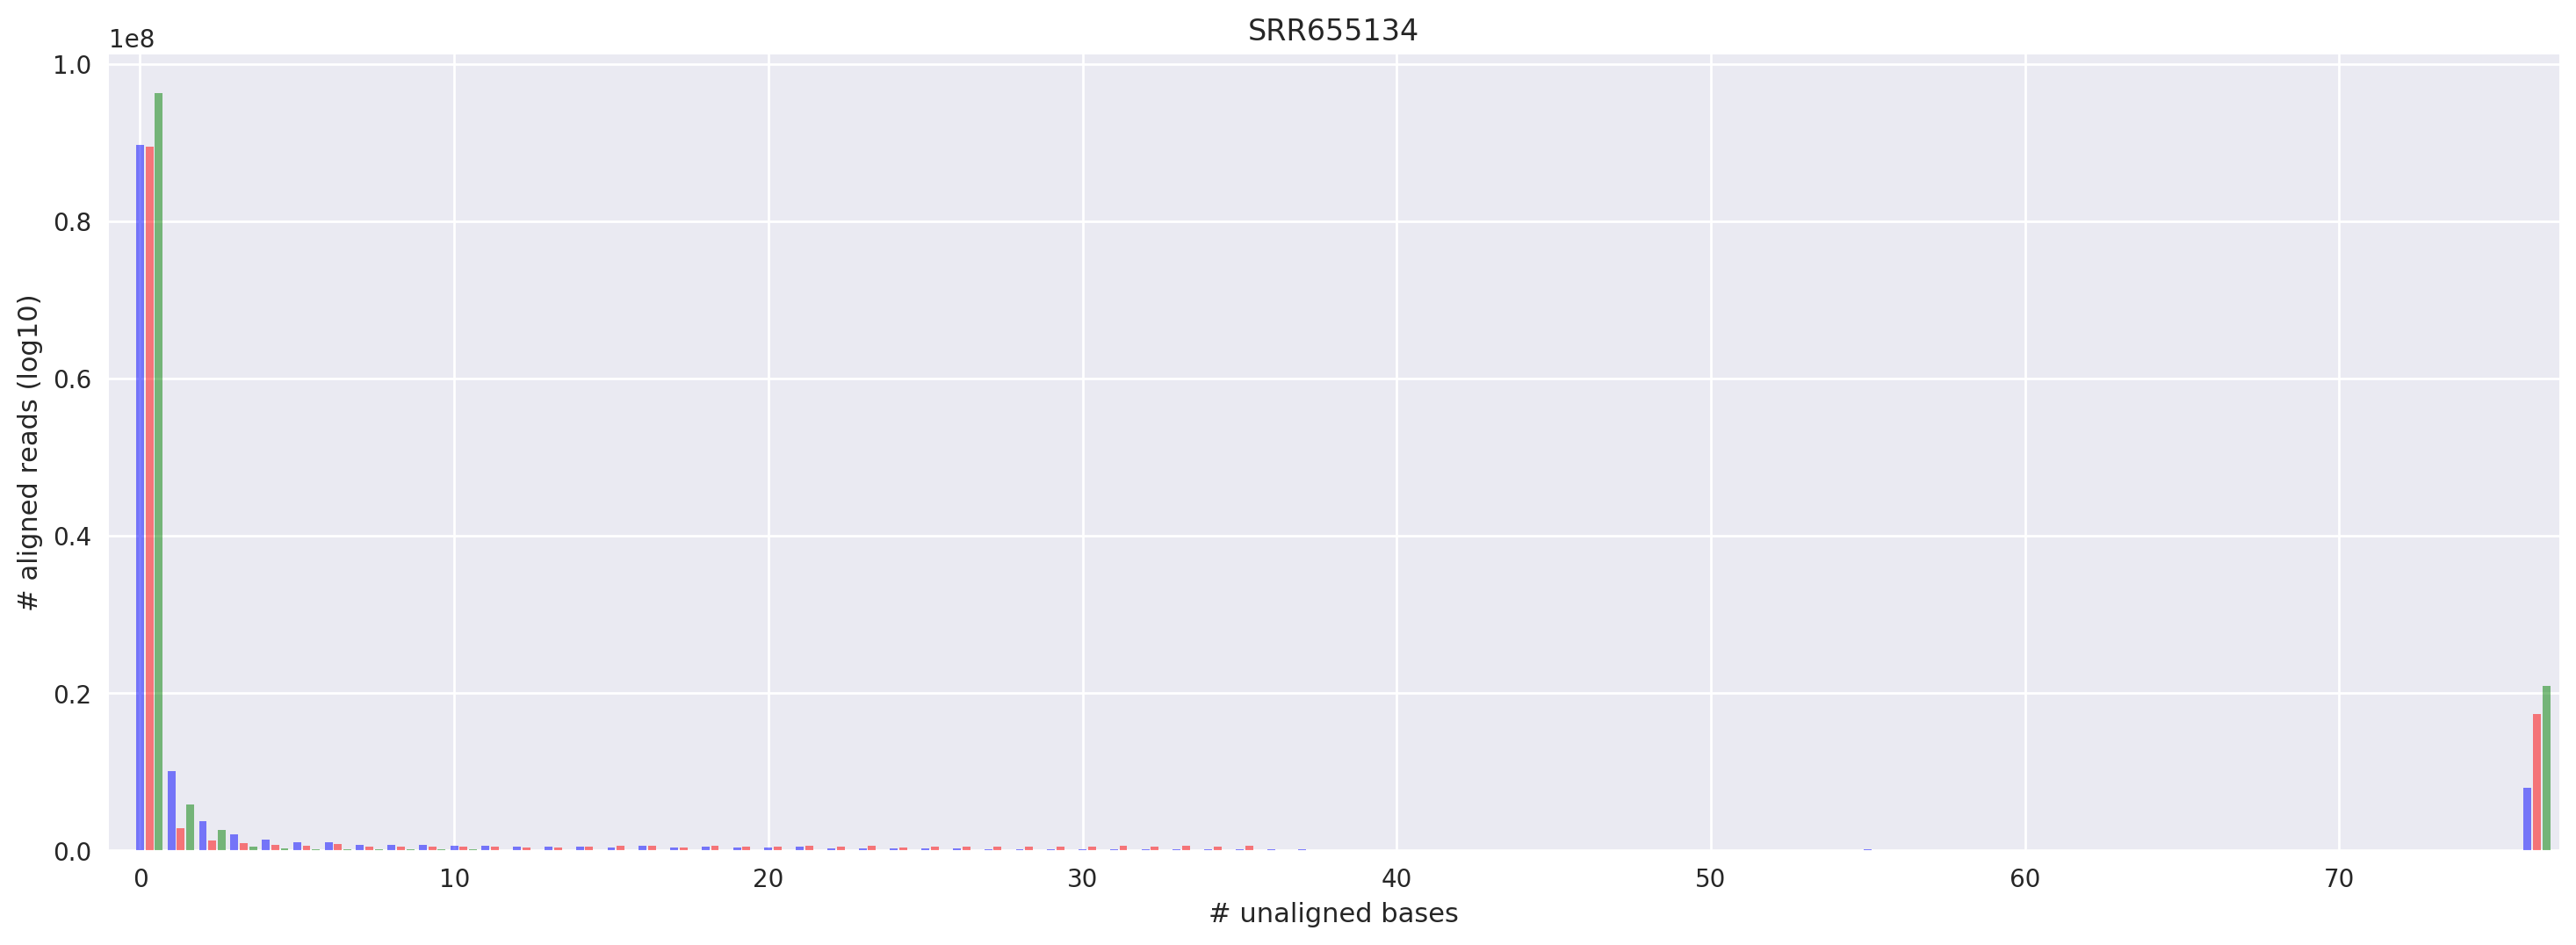

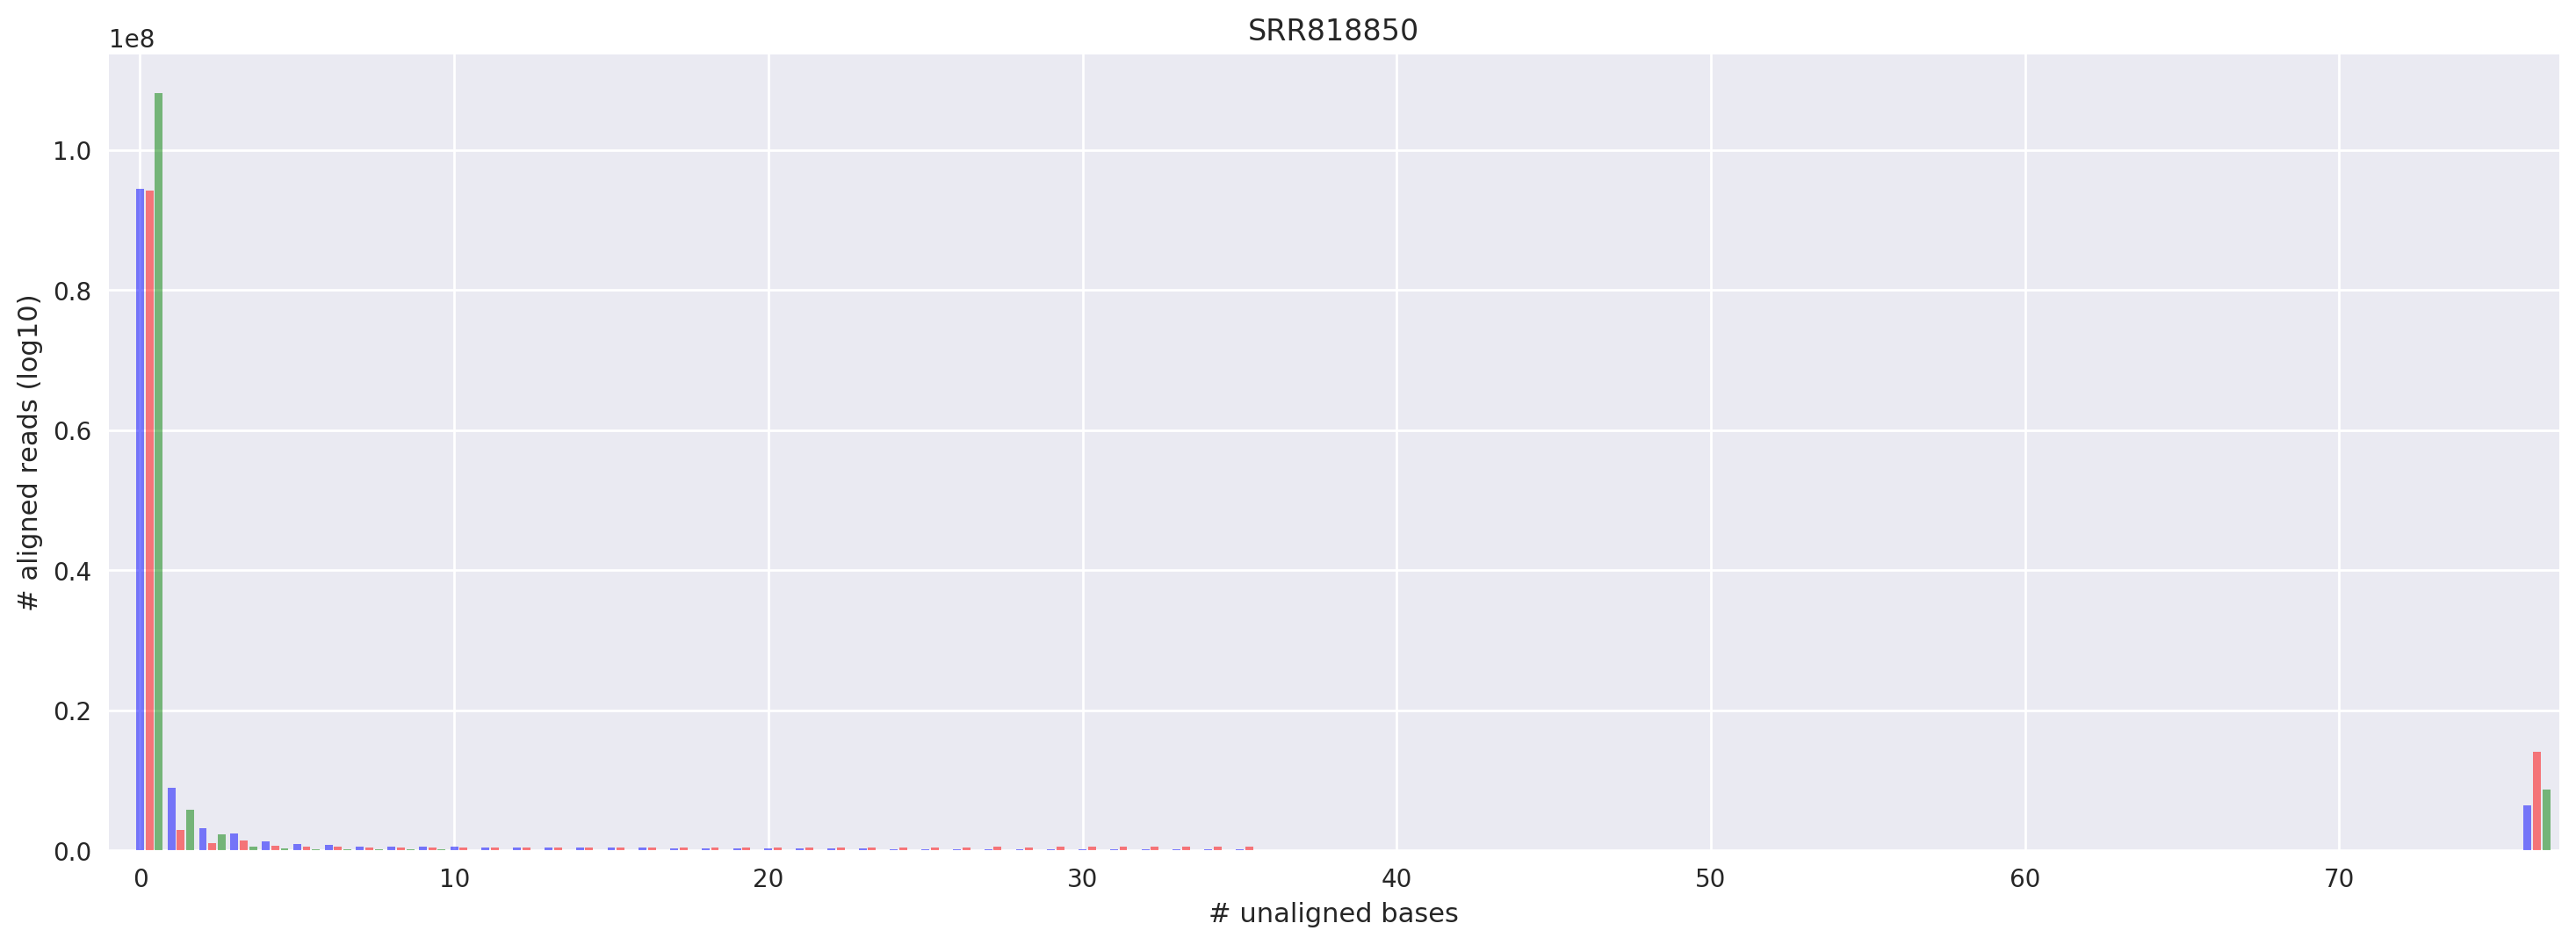

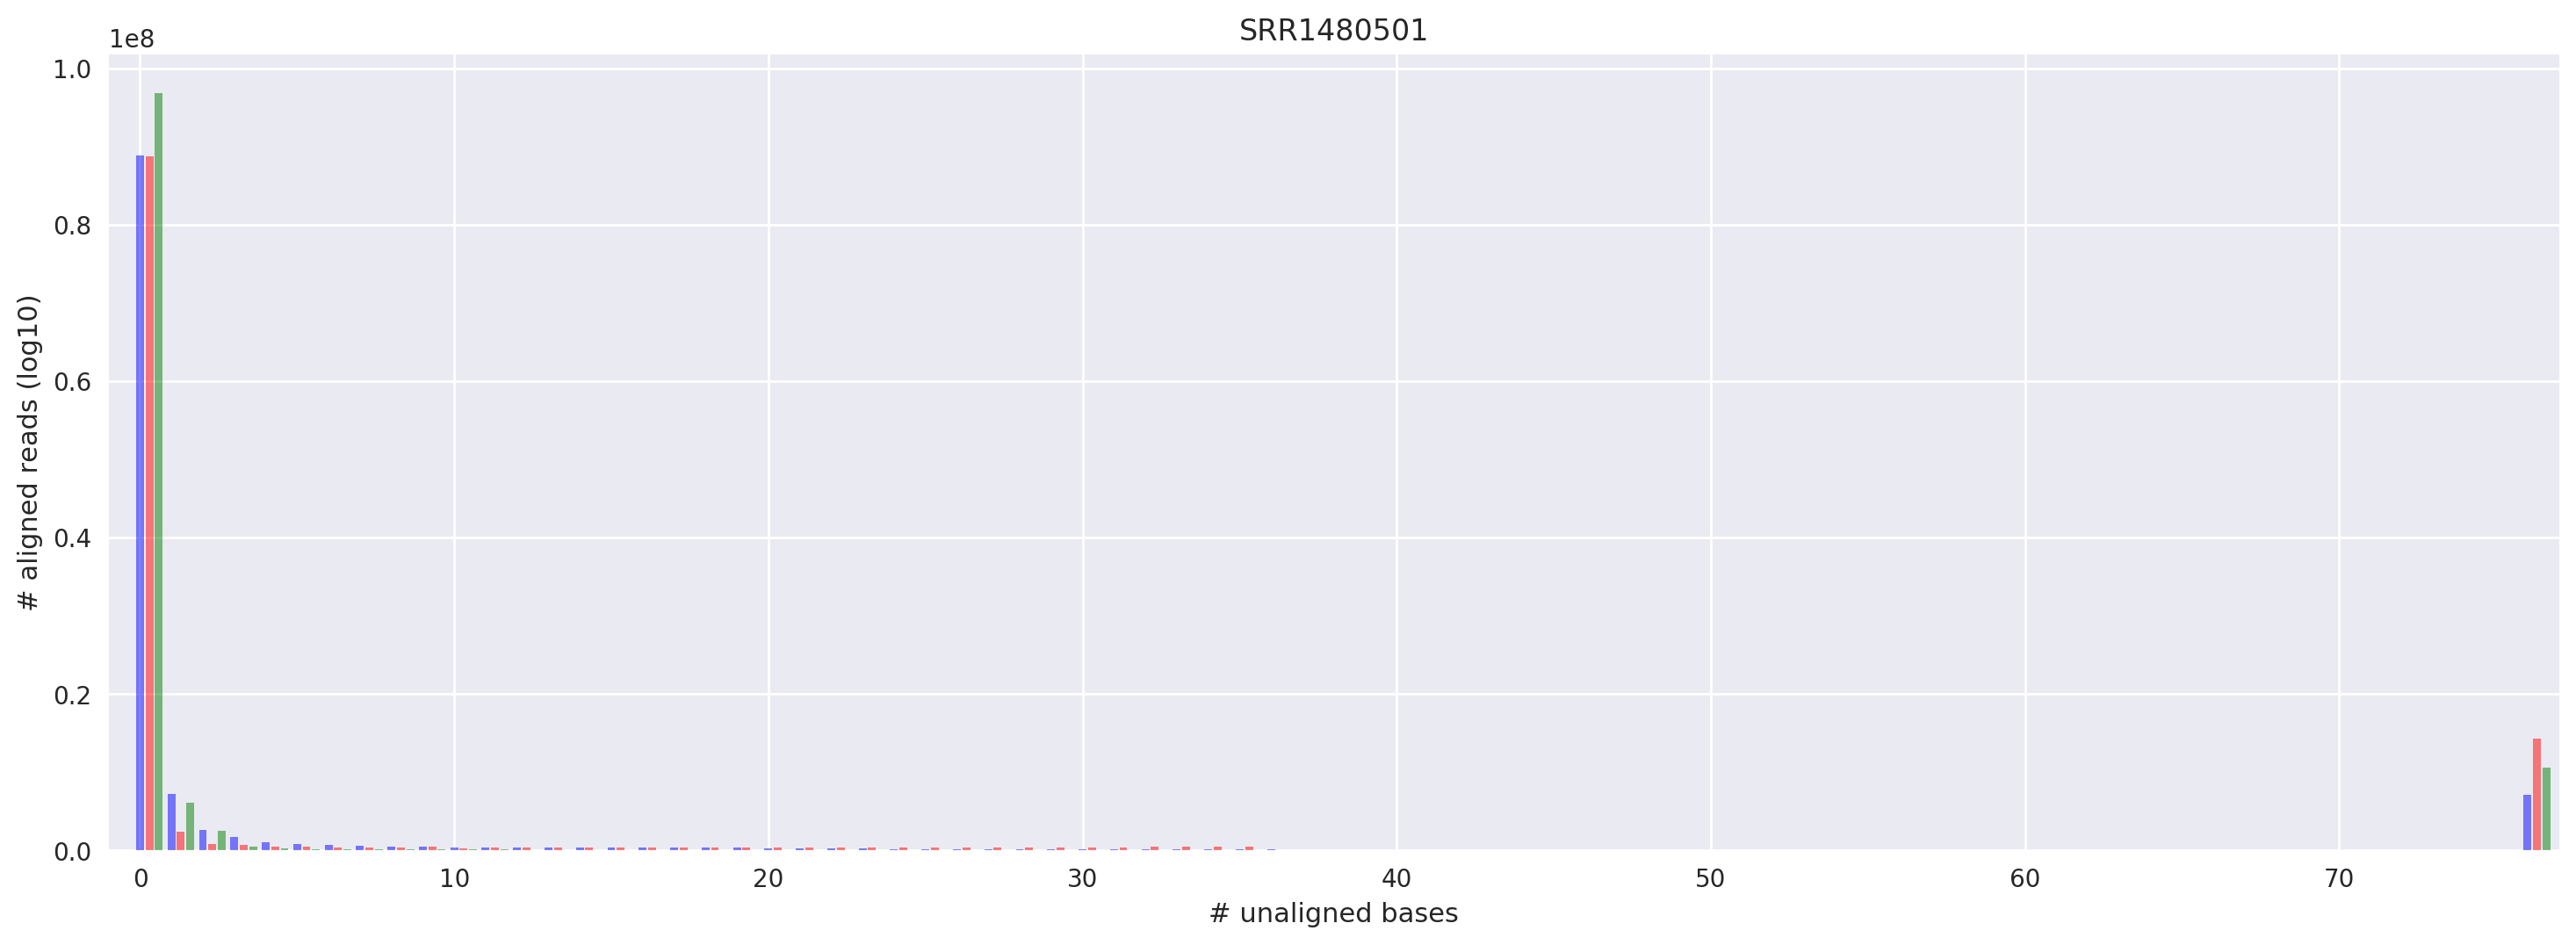

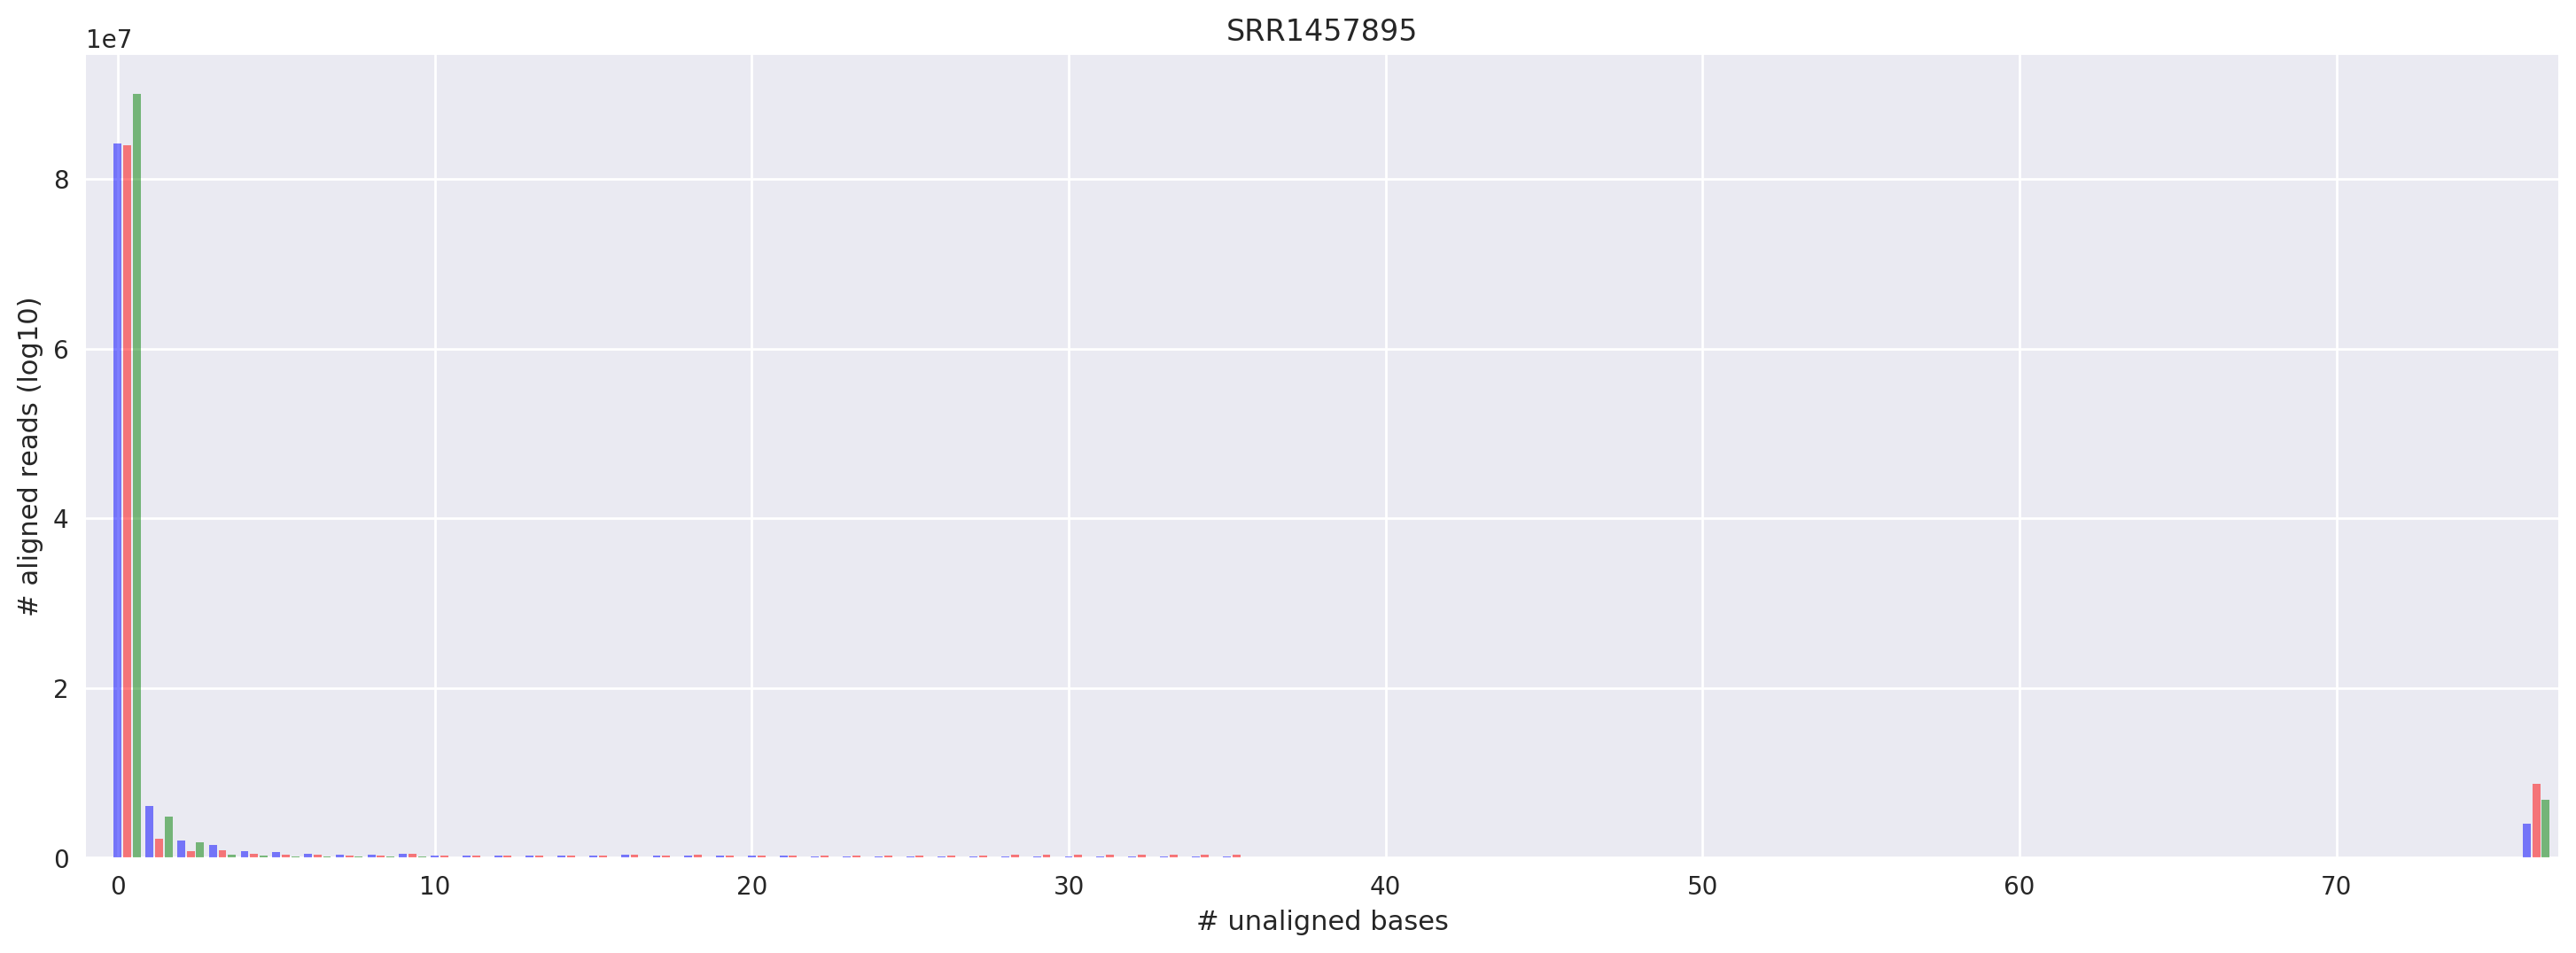

In [28]:
with plt.style.context('seaborn'):
    for idx in df['meta_align'].index[:5]:
        fig = plt.figure(figsize=(18, 6), dpi=200)
        ax = fig.add_subplot(111)
        #ax.bar(sp.arange(df['meta'].shape[1]), sp.log10(df['meta'].loc[idx] + 1), color='b', alpha=0.5)
        #ax.bar(sp.arange(df['star'].shape[1]), sp.log10(df['star'].loc[idx] + 1), color='r', alpha=0.5)
        ax.bar(sp.arange(df['meta_align'].shape[1]), df['meta_align'].loc[idx], width=0.25, color='b', alpha=0.5)
        ax.bar(sp.arange(df['meta_map'].shape[1]) + 0.3, df['meta_map'].loc[idx], color='r', width=0.25, alpha=0.5)
        ax.bar(sp.arange(df['star'].shape[1]) + 0.6, df['star'].loc[idx], color='g', width=0.25, alpha=0.5)
        ax.set_xlim([-1, 77])
        ax.set_xlabel('# unaligned bases')
        ax.set_ylabel('# aligned reads (log10)')
        ax.set_title(idx)

In [66]:
df['meta'].shape

(38, 77)